**Анализ поведения клиентов фитнес клуба.**

Проект выполнен с использованием открытых данных с kaggle. Согласно описанию, датасет имеет синтетическую природу. 

Цель: изучить паттерны потребительского поведения клиентов фитнес клуба

In [1]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.offline as pyo
import plotly.graph_objects as go
import plotly.express as px
pyo.init_notebook_mode(connected=True)


import scipy.stats as stats
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Install dependencies as needed:
#%pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "gym_membership.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "ka66ledata/gym-membership-dataset",
  file_path,
  # Provide any additional arguments like 
  # sql_query or pandas_kwargs. See the 
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

In [3]:
if df.duplicated().sum() == 0:
    print('Дубликатов нет')
else:
    print(f'В датасете найдено {df.duplicated().sum()} дубликатов')

Дубликатов нет


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     1000 non-null   int64 
 1   gender                 1000 non-null   object
 2   birthday               1000 non-null   object
 3   Age                    1000 non-null   int64 
 4   abonoment_type         1000 non-null   object
 5   visit_per_week         1000 non-null   int64 
 6   days_per_week          1000 non-null   object
 7   attend_group_lesson    1000 non-null   bool  
 8   fav_group_lesson       503 non-null    object
 9   avg_time_check_in      1000 non-null   object
 10  avg_time_check_out     1000 non-null   object
 11  avg_time_in_gym        1000 non-null   int64 
 12  drink_abo              1000 non-null   bool  
 13  fav_drink              496 non-null    object
 14  personal_training      1000 non-null   bool  
 15  name_personal_trainer 

In [5]:
df.head(5)

,id,gender,birthday,Age,abonoment_type,visit_per_week,days_per_week,attend_group_lesson,fav_group_lesson,avg_time_check_in,avg_time_check_out,avg_time_in_gym,drink_abo,fav_drink,personal_training,name_personal_trainer,uses_sauna
0,1,Female,1997-04-18,27,Premium,4,"Mon, Sat, Tue, Wed",True,"Kickboxen, BodyPump, Zumba",19:31:00,21:27:00,116,False,NaN,False,NaN,True
1,2,Female,1977-09-18,47,Standard,3,"Mon, Sat, Wed",False,NaN,19:31:00,20:19:00,48,False,NaN,True,Chantal,False
2,3,Male,1983-03-30,41,Premium,1,Sat,True,XCore,08:29:00,10:32:00,123,True,"berry_boost, lemon",True,Mike,False
3,4,Male,1980-04-12,44,Premium,3,"Sat, Tue, Wed",False,NaN,09:54:00,11:33:00,99,True,passion_fruit,True,Mike,True
4,5,Male,1980-09-10,44,Standard,2,"Thu, Wed",True,"Running, Yoga, Zumba",08:29:00,09:19:00,50,False,NaN,True,Mike,False


**Структура данных**

Датасет состоит из 17 столбцов, с учетом уникального ключа id.
В нем представленны переменные различных типов:
* Категориальные:
    * Пол
    * Тип абонемента
    * Дни посещения
    * Любимые групповые занятия
    * Любимый напиток
    * Имя персонального тренера
* Числовые:
    * Возраст
    * Количество посещений в неделю
    * Среднее время в зале
* Булевы дихотомии: 
    * Посещение групповых занятий
    * Абонемент с напитками
    * Персональные тренировки
    * Посещение сауны
* Временные данные:
    * Дата рождения
    * Среднее время входа в зал
    * Среднее время выхода

Стоит сделать замечание, что дни посещения, любимые напитки и любимые групповые занятия хранятся в одной колонке, через запятую. Что фактически создает множество категорий, каждая их которых содержит свой набор значений.

Временные данные храятся в формате объектов, не поддерживающих математические операции.

Также можно заметить опечатку в колонке с индексом 4

In [6]:
df.rename(columns={'Age':'age',
                   'abonoment_type':'abonement_type'},
                   inplace=True
                   )
#приведение Age к нижнему регистру для соответсвия общему стилю заголовков

In [7]:
for i in ['avg_time_check_in','avg_time_check_out']:
    df[i] = pd.to_timedelta(df[i])

Датасет имеет 1000 записей. Видно, что в некоторых колонках существуют null значения.
Эти пропуски являются естественными: 
* не все люди посещают групповые занятия, часть занимается индивидуально (fav_group_lesson)
* не у всех есть любимый напиток, так как не все прибретают их в зале, посетитель может приносить с собой или просто воздеживаться от покупки (fav_drink)
* часть людей тренируется самостоятельно или в группах, что обуславливает отсутсвие персонального тренера/инструктора (name_personal_trainer)

В этом можно легко убедиться: датасет содержит связанные с описанными выше колонки с булевым типом данных.

In [8]:
nan_cols = ['fav_group_lesson', 'fav_drink', 'name_personal_trainer']
connected_cols = ['attend_group_lesson', 'drink_abo', 'personal_training']

for i,j in zip(nan_cols,connected_cols):
    print(f'Количество людей без соотвествующей опции {j}:{df[j].value_counts().loc[False]}')
    print(f'Количество пропусков по опции {i}: {df[i].isna().sum()}')

Количество людей без соотвествующей опции attend_group_lesson:497
Количество пропусков по опции fav_group_lesson: 497
Количество людей без соотвествующей опции drink_abo:504
Количество пропусков по опции fav_drink: 504
Количество людей без соотвествующей опции personal_training:482
Количество пропусков по опции name_personal_trainer: 482


Объяснение природы пропусков подтвердилось

In [9]:
#заполним пропуски
for i in nan_cols:
    df.fillna({i:'No'}, inplace=True)

In [10]:
df.describe()

,id,age,visit_per_week,avg_time_check_in,avg_time_check_out,avg_time_in_gym
count,1000.000000,1000.000000,1000.000000,1000,1000,1000.000000
mean,500.500000,30.604000,2.682000,0 days 14:24:06.720000,0 days 16:09:22.320000,105.260000
std,288.819436,10.817958,1.241941,0 days 03:46:33.053797920,0 days 03:49:41.930409903,43.557177
min,1.000000,12.000000,1.000000,0 days 08:00:00,0 days 08:47:00,30.000000
25%,250.750000,21.000000,2.000000,0 days 10:55:45,0 days 12:48:45,67.000000
50%,500.500000,30.000000,3.000000,0 days 14:20:00,0 days 16:06:30,104.000000
75%,750.250000,40.000000,3.000000,0 days 17:41:15,0 days 19:28:30,143.000000
max,1000.000000,49.000000,5.000000,0 days 20:58:00,0 days 23:49:00,180.000000


In [11]:
df.columns

Index(['id', 'gender', 'birthday', 'age', 'abonement_type', 'visit_per_week',
       'days_per_week', 'attend_group_lesson', 'fav_group_lesson',
       'avg_time_check_in', 'avg_time_check_out', 'avg_time_in_gym',
       'drink_abo', 'fav_drink', 'personal_training', 'name_personal_trainer',
       'uses_sauna'],
      dtype='object')

Text(0, 0.5, 'Частота')

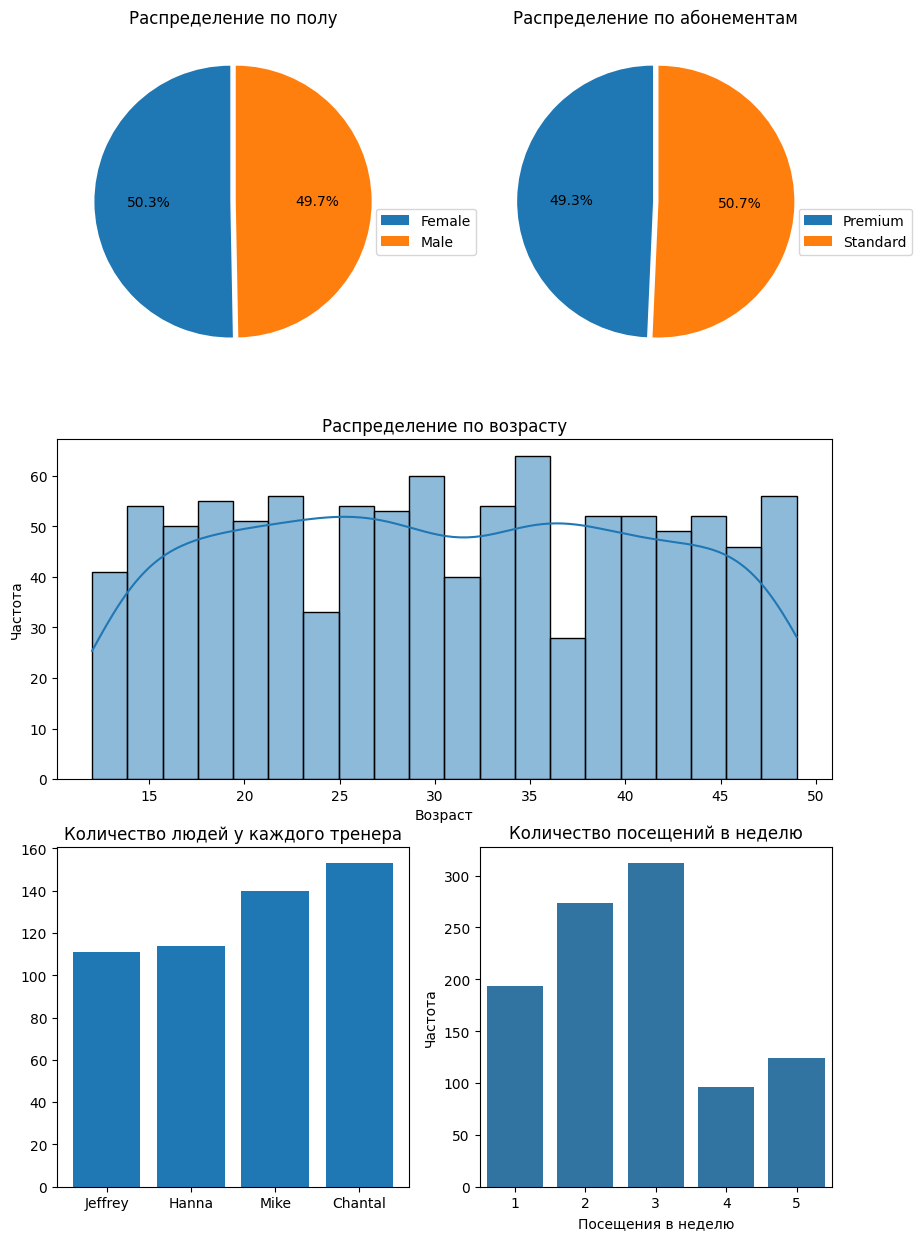

In [12]:
fig = plt.figure(figsize=(10,15))

layout = """
    AB
    CC
    DE
"""

ax = fig.subplot_mosaic(layout)

gender_freq = df.groupby(by='gender').agg(
    freq=pd.NamedAgg(column='gender', aggfunc='count')
    )
ax['A'].pie(data=gender_freq,
          x=gender_freq.freq,
          autopct='%1.1f%%',
          explode=[0.02,0.02],
          startangle= 90)
ax['A'].legend(gender_freq.index, bbox_to_anchor=(0.9,0.5))
ax['A'].set_title('Распределение по полу')
 
abo_df = df.groupby(by='abonement_type').agg(
    freq= pd.NamedAgg(column='abonement_type', aggfunc='count')
)
ax['B'].pie(x=abo_df['freq'],
        autopct='%1.1f%%', 
        startangle= 90,
        explode= [0.02,0.02])
ax['B'].legend(abo_df.index, bbox_to_anchor=(0.9,0.5))
ax['B'].set_title('Распределение по абонементам')

sns.histplot(data=df,
             x='age',
             ax=ax['C'],
             bins=20,
             kde=True)
ax['C'].set_title('Распределение по возрасту')
ax['C'].set_xlabel('Возраст')
ax['C'].set_ylabel('Частота')

trainer_df = df.groupby(by='name_personal_trainer').agg(
    freq= pd.NamedAgg(column='name_personal_trainer', aggfunc='count')
)
trainer_df = trainer_df.sort_values(by='freq')
ax['D'].bar(data= trainer_df,
        x=trainer_df.index[:-1], #исключаем последнюю строку, там без тренера
        height=trainer_df.freq[:-1],
)
ax['D'].set_title('Количество людей у каждого тренера',x=0.5)


visit_w_freq= df.groupby(by='visit_per_week').agg(
    freq= pd.NamedAgg(column='visit_per_week',aggfunc='count')
)
sns.barplot(
            data=visit_w_freq,
            x=visit_w_freq.index,
            y=visit_w_freq.freq,
            ax=ax['E']
            )
ax['E'].set_title('Количество посещений в неделю', x=0.5)
ax['E'].set_xlabel('Посещения в неделю',x= 0.5)
ax['E'].set_ylabel('Частота')

In [13]:
data_frame= df.groupby(by=['gender','abonement_type']).agg({'id':'count'})
cross = data_frame.unstack()
cross.columns = cross.columns.droplevel(0)

chi2, p_val, dof, exp = stats.chi2_contingency(cross)

print(cross)
print(f'\nХи2:{chi2} \nP_value:{p_val}\n')
print(exp)

abonement_type  Premium  Standard
gender                           
Female              242       261
Male                251       246

Хи2:0.4804225106326079 
P_value:0.48823099898636313

[[247.979 255.021]
 [245.021 251.979]]


In [14]:
days = df['days_per_week'].str.split(', ').explode()
days = days.value_counts().reindex(index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

fig = px.bar(data_frame=days)
fig.update_layout(title='Посещений в дни недели', title_x= 0.5)

In [15]:
##посещения по дням недели / абонемент
df_dummies = df['days_per_week'].str.get_dummies(sep=', ')
df_days = pd.concat([df, df_dummies], axis=1)

lst = days.index.tolist()
lst.append('abonement_type')
days_abo = df_days[lst].groupby('abonement_type').agg('sum')

days_abo = days_abo.reset_index().melt(id_vars='abonement_type')
px.bar(data_frame=days_abo, 
       x='variable', 
       y='value', 
       facet_col='abonement_type',
       text_auto=True)

In [16]:
data_frame = df.groupby(by=['gender','abonement_type','visit_per_week']).agg(visits = pd.NamedAgg(column = 'visit_per_week', aggfunc='count')).reset_index()
px.bar(data_frame,
       x='visit_per_week',
       y='visits',
       facet_col = 'gender',
       facet_row = 'abonement_type',
       text_auto=True)

In [17]:
group_lessons = df['fav_group_lesson'].str.split(', ').explode()
group_lessons.value_counts()

fig = px.bar(data_frame=group_lessons.value_counts()[1:],
             text_auto=True) #исключаем без групповых занятий
fig.update_layout(title='Любимые групповые занятия', title_x= 0.5)

In [18]:
(group_lessons.value_counts()[1:]/(group_lessons.value_counts()[1:].values.sum()/100)).round(3)

fav_group_lesson
BodyPump       11.167
LesMiles        9.870
HIT             9.671
Pilates         9.472
XCore           8.973
Yoga            8.973
BodyBalance     8.674
Spinning        8.475
Kickboxen       8.475
Running         8.175
Zumba           8.076
Name: count, dtype: float64

In [19]:
lst = pd.unique(group_lessons)
lst

array(['Kickboxen', 'BodyPump', 'Zumba', 'No', 'XCore', 'Running', 'Yoga',
       'LesMiles', 'Pilates', 'HIT', 'Spinning', 'BodyBalance'],
      dtype=object)

In [20]:
#группвые/абонемент
df_dummies = df['fav_group_lesson'].str.get_dummies(sep=', ')
df_extended = pd.concat([df, df_dummies], axis=1)

lst = pd.unique(group_lessons).tolist()
lst.append('abonement_type')
fav_gr_lesson = df_extended[lst].groupby('abonement_type').agg('sum')
fav_gr_lesson = fav_gr_lesson.reset_index().melt(id_vars='abonement_type')


px.bar(data_frame=fav_gr_lesson[fav_gr_lesson['variable']!='No'],
       x='variable',
       y='value',
       facet_col='abonement_type',
       text_auto=True)

In [21]:
drinks = df['fav_drink'].str.split(', ').explode()
drinks.value_counts()

fig = px.bar(data_frame=drinks.value_counts()[1:], text_auto = True) #исключаем без абонемента на напитки
fig.update_layout(title='Любимые напитки', title_x= 0.5)

In [22]:
(drinks.value_counts()[1:]/(drinks.value_counts()[1:].values.sum()/100)).round(1)

fav_drink
coconut_pineapple    18.6
orange               17.5
passion_fruit        16.6
lemon                16.0
berry_boost          15.9
black_currant        15.4
Name: count, dtype: float64

In [23]:
df_dummies = df['fav_drink'].str.get_dummies(sep=', ')
df_extended = pd.concat([df, df_dummies], axis=1)
lst = df_extended.iloc[:,-7:].columns
fav_drinks = df_extended.groupby('abonement_type').agg(
    No = pd.NamedAgg(column=lst[0], aggfunc='sum'),
    berry_boost =pd.NamedAgg(column=lst[1], aggfunc='sum'),
    black_currant =pd.NamedAgg(column=lst[2], aggfunc='sum'),
    coconut_pineapple =pd.NamedAgg(column=lst[3], aggfunc='sum'),
    lemon =pd.NamedAgg(column=lst[4], aggfunc='sum'),
    orange =pd.NamedAgg(column=lst[5], aggfunc='sum'),
    passion_fruit =pd.NamedAgg(column=lst[6], aggfunc='sum')
)

fav_drinks_mlt = fav_drinks.drop(columns='No').reset_index().melt(id_vars = 'abonement_type', var_name= 'drink', value_name='count')
fig = px.histogram(data_frame=fav_drinks_mlt, x='drink', y='count', color='abonement_type', barmode= 'group')
fig.update_layout(title = 'Любимые напитки в разрезе абонементов', title_x=0.5)

In [24]:
df_dummies = df['fav_drink'].str.get_dummies(sep=', ')
df_drinks = pd.concat([df, df_dummies], axis=1)

In [25]:
age_grs_lst = ['младше 14','14-17', '18-20', '21-25', '26-30', '31-35', '36-40', '41-45', 'старше 45']
age_cond= [(df['age']<14),
           (df['age']>13) & (df['age']<18),
           (df['age']>17) & (df['age']<21),
           (df['age']>20) & (df['age']<26),
           (df['age']>25) & (df['age']<31),
           (df['age']>30) & (df['age']<36),
           (df['age']>35) & (df['age']<41),
           (df['age']>40) & (df['age']<46),
           (df['age']>45)]
df['age_group'] = np.select(age_cond, age_grs_lst, default='Unknown')
df[['age','age_group']].sample(3)


,age,age_group
639,17,14-17
83,18,18-20
906,48,старше 45


In [26]:
##разбиение количественной age на категориальную переменную
age_grs_lst= ['младше 18', '18-25', '26-35', '36-45', '46-55', '56-65', 'старше 65']
age_cond= [(df['age']<18),
           (df['age']>17) & (df['age']<26),
           (df['age']>25) & (df['age']<36),
           (df['age']>35) & (df['age']<46),
           (df['age']>45) & (df['age']<56),
           (df['age']>55) & (df['age']<66),
           (df['age']>65)]
df['age_group'] = np.select(age_cond, age_grs_lst, default='Unknown')
df[['age','age_group']].sample(3)

,age,age_group
875,12,младше 18
951,42,36-45
481,19,18-25


In [27]:
fig = px.scatter(data_frame=df, 
                x='avg_time_check_in',
                y='avg_time_in_gym',
                facet_col='abonement_type',
                facet_row='gender')
fig.show()

In [28]:
df.groupby(by='gender').agg({'age':['median','mean']})

age           
       median       mean
gender                  
Female   29.0  29.825050
Male     32.0  31.392354

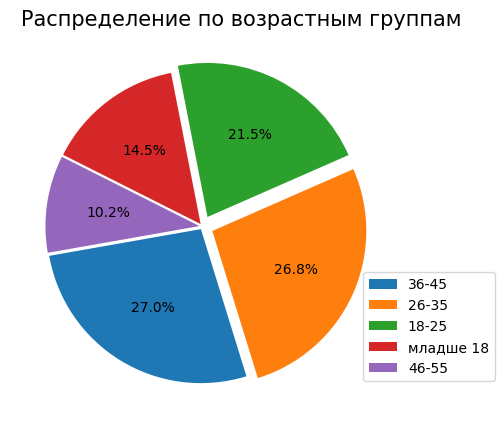

In [29]:
plt.figure(figsize=(5,5))
plt.pie(
        x=df['age_group'].value_counts(),
        autopct='%1.1f%%',
        explode= [0.02, 0.07, 0.07, 0.02, 0.02],
        startangle=190
        )
plt.legend(df['age_group'].value_counts().index, bbox_to_anchor=(0.9,0.4))
plt.title('Распределение по возрастным группам',fontsize=15,x=0.6)
plt.show()

In [30]:
age_grs_lst= ['младше 14','14-17', '18-20', '21-25', '26-30', '31-35', '36-40', '41-45', 'старше 45']
age_cond= [(df['age']<14),
           (df['age']>13) & (df['age']<18),
           (df['age']>17) & (df['age']<21),
           (df['age']>20) & (df['age']<26),
           (df['age']>25) & (df['age']<31),
           (df['age']>30) & (df['age']<36),
           (df['age']>35) & (df['age']<41),
           (df['age']>40) & (df['age']<46),
           (df['age']>45)]
df['age_group'] = np.select(age_cond, age_grs_lst, default='Unknown')
df[['age','age_group']].sample(3)

age_freq= df.groupby(by='age_group', as_index=False).agg(
    freq= pd.NamedAgg(column='age_group',aggfunc='count')
)

px.bar(data_frame=age_freq,
       x='age_group',
       y='freq',
       category_orders={'age_group':age_grs_lst},
       text_auto=True)

In [31]:
age_perc = age_freq.groupby('age_group').agg({'freq':'sum'}).loc[age_grs_lst]/10
age_perc.cumsum()

,freq
age_group,
младше 14,4.1
14-17,14.5
18-20,22.8
21-25,36.0
26-30,50.7
31-35,62.8
36-40,77.0
41-45,89.8
старше 45,100.0


In [32]:
print(f'{(100-(100-89.8))-22.8}% посетителей зала имеют возраст от 21 до 45 лет')

67.0% посетителей зала имеют возраст от 21 до 45 лет


In [33]:
age_freq= df.groupby(by=['gender','age_group'], as_index=False).agg(
    freq= pd.NamedAgg(column='age_group',aggfunc='count'))

px.bar(data_frame=age_freq,
       x='age_group',
       y='freq',
       category_orders={'age_group':age_grs_lst},
       hover_data='gender',
       text_auto=True,
       facet_col='gender')

In [34]:
24/((63+39)/100)

23.52941176470588

In [35]:
18/((75+57)/100)

13.636363636363635

Основная аудитория для этого зала: взрослые люди старше 20 лет 

Заметный перекос по полу в следующих возрастных группах:
* 21-25 лет: женщин на 18 (13.6%) больше
* старше 45: мужчин на 24 (23.5%) больше

In [36]:
##45+ мужчины
##24/(39+63)

In [37]:
df_extended = pd.DataFrame()

df_extended['abonement_type']=df['abonement_type']
df_extended['gender']=df['gender']
df_extended['check_in']=df['avg_time_check_in']
df_extended['check_out']=df['avg_time_check_out']
df_extended['avg_time']=df['avg_time_in_gym']
df_extended['age_group']=df['age_group']
df_extended['visit_per_week']=df['visit_per_week']

In [38]:
fig = px.box(data_frame=df,
             x='age_group',
             y='avg_time_in_gym',
             color= 'gender')
fig.update_traces(boxmean=True)


In [39]:
df.groupby(by=['gender','abonement_type']).agg(
    abo_count = pd.NamedAgg(column='abonement_type', aggfunc='count'),
    avg_time = pd.NamedAgg(column='avg_time_in_gym',aggfunc='mean'),
    week_mean_visits = pd.NamedAgg(column='visit_per_week', aggfunc='mean')
    )

abo_count    avg_time  week_mean_visits
gender abonement_type                                         
Female Premium               242  104.871901          2.677686
       Standard              261  107.597701          2.754789
Male   Premium               251  104.944223          2.689243
       Standard              246  103.483740          2.601626

In [40]:
def t_test_fm(data, variable):
#функция проверяет связь значения выбранной переменной и пола
    group_f = data[data['gender']=='Female'][variable]
    group_m = data[data['gender']=='Male'][variable]

    groups = group_f, group_m
    
    result = {}
    i=0
    for group in groups: #проверка на нормальность
        i+=1
        shap, p_val = stats.shapiro(group)
        result[f'group_{i}'] = [shap, p_val]
        
    
    if (result['group_1'][1] > 0.05) & (result['group_1'][1] > 0.05):
        print('Данные распределены нормально')
        lev, p_lev = stats.levene(groups[0],groups[1])
        if p_lev > 0.05: # проверка равенства дисперсий
            print('Дисперсии в группах равны')
            t_stat, p_val = stats.ttest_ind(groups[0],groups[1], equal_var=True)
            print(f'\nТ-Стьюдент: {t_stat}, p-value{p_val}')
        else: 
            print('Дисперсии в группах не равны')
            t_stat, p_val = stats.ttest_ind(groups[0],groups[1], equal_var=False)
            print(f'\nТ-Уэлч: {t_stat}, p-value{p_val}')
    else:
        u_stat, p_val = stats.mannwhitneyu(groups[0],groups[1])
        print('Данные распределены не нормально')
        print(f'\nU-критерий: {u_stat}, p-value = {p_val}')
        if p_val < 0.05:
            print(f'Связь между полом и {variable} есть')
        else:
            print(f'Связи между полом и {variable} нет')

t_test_fm(df_extended, 'avg_time')

Данные распределены не нормально

U-критерий: 128515.5, p-value = 0.44086317913127515
Связи между полом и avg_time нет


In [41]:
def t_test_ps(data, variable):
#функция проверяет связь значения выбранной переменной и типа абонемента
    group_f = data[data['abonement_type']=='Premium'][variable]
    group_m = data[data['abonement_type']=='Standard'][variable]

    groups = group_f, group_m
    
    result = {}
    i=0
    for group in groups: #проверка на нормальность
        i+=1
        shap, p_val = stats.shapiro(group)
        result[f'group_{i}'] = [shap, p_val]
        
    
    if (result['group_1'][1] > 0.05) & (result['group_1'][1] > 0.05):
        print('Данные распределены нормально')
        lev, p_lev = stats.levene(groups[0],groups[1])
        if p_lev > 0.05: # проверка равенства дисперсий
            print('Дисперсии в группах равны')
            t_stat, p_val = stats.ttest_ind(groups[0],groups[1], equal_var=True)
            print(f'\nТ-Стьюдент: {t_stat}, p-value{p_val}')
        else: 
            print('Дисперсии в группах не равны')
            t_stat, p_val = stats.ttest_ind(groups[0],groups[1], equal_var=False)
            print(f'\nТ-Уэлч: {t_stat}, p-value{p_val}')
    else:
        u_stat, p_val = stats.mannwhitneyu(groups[0],groups[1])
        print('Данные распределены не нормально')
        print(f'\nU-критерий: {u_stat}, p-value = {p_val}')
        if p_val < 0.05:
            print(f'Связь между типом абонемента и {variable} есть')
        else:
            print(f'Связи между типом абонемента и {variable} нет')

t_test_ps(df_extended, 'avg_time')

Данные распределены не нормально

U-критерий: 123890.5, p-value = 0.8122580582653476
Связи между типом абонемента и avg_time нет


In [42]:
def categorize_time(time):
    if pd.to_timedelta('05:00:00') <= time < pd.to_timedelta('12:00:00'):
        return 'Утро'
    elif pd.to_timedelta('12:00:00') <= time < pd.to_timedelta('18:00:00'):
        return 'День'
    else:
        return 'Вечер/ночь'

df_extended['check_in_cat'] = df['avg_time_check_in'].apply(categorize_time)


In [43]:
cross = pd.crosstab(df_extended['gender'],df_extended['check_in_cat'])

chi_2, p_val, dof, exp = stats.chi2_contingency(cross) 
print(f'Хи2 = {chi_2}, P-value = {p_val}')
if p_val >= 0.05:
    print('Связи между полом временем захода в зал нет, нет оснований отвергнуть нулевую гипотезу')
    print('\nНаблюдаемые частоты:')
    display(cross)
else:
    print('Есть связь между переменными')
    px.density_heatmap(cross)

Хи2 = 4.575404487500084, P-value = 0.10149941503183635
Связи между полом временем захода в зал нет, нет оснований отвергнуть нулевую гипотезу

Наблюдаемые частоты:


check_in_cat,Вечер/ночь,День,Утро
gender,,,
Female,103,217,183
Male,118,229,150


In [44]:
df_extended['check_in_hour'] = df_extended['check_in'].dt.total_seconds() / 3600

In [45]:
t_test_fm(df_extended, 'check_in_hour')

Данные распределены не нормально

U-критерий: 115918.5, p-value = 0.04685491517061679
Связь между полом и check_in_hour есть


In [46]:
fig=px.box(data_frame=df_extended, x='gender', y= 'check_in_hour')
fig.update_traces(boxmean=True)

На выборке было выявлено значимое различие в разнице захода в зал между мужинами и женщинами. В среднем женщины приходят раньше мужчин

Такое поведение может быть связано с тем, что посетители женского пола раньше приходят домой с работы/освобождаются от домашних дел. Или, возможно, им свойственно избегать "пик часы" зала, которые приходятся на более позднее время.

In [47]:
df_extended.columns

Index(['abonement_type', 'gender', 'check_in', 'check_out', 'avg_time',
       'age_group', 'visit_per_week', 'check_in_cat', 'check_in_hour'],
      dtype='object')

In [48]:
t_test_fm(df_extended, 'visit_per_week')

Данные распределены не нормально

U-критерий: 128879.5, p-value = 0.3801464046771059
Связи между полом и visit_per_week нет


In [49]:
t_test_ps(df_extended, 'visit_per_week')

Данные распределены не нормально

U-критерий: 125023.5, p-value = 0.99143462205215
Связи между типом абонемента и visit_per_week нет


In [50]:
cross = pd.crosstab(df['visit_per_week'],df_extended['gender'])
chi_2, p_val, dof, expected = stats.chi2_contingency(cross)

print('Наблюдения:')
print(cross)
if p_val > 0.05:
    print('Связи между полом и количеством посещений нет')
else:
    print('Связь между полом и количеством посещений есть')
print(f'Хи2 = {chi_2}, p-value = {p_val}')
print(f'Степени свободы: {dof}')
print('Ожидаемые частоты:')
print(expected)


Наблюдения:
gender          Female  Male
visit_per_week              
1                   98    96
2                  132   142
3                  152   160
4                   56    40
5                   65    59
Связи между полом и количеством посещений нет
Хи2 = 3.511825938524489, p-value = 0.47608246438400814
Степени свободы: 4
Ожидаемые частоты:
[[ 97.582  96.418]
 [137.822 136.178]
 [156.936 155.064]
 [ 48.288  47.712]
 [ 62.372  61.628]]


In [51]:
cross = pd.crosstab(df['visit_per_week'],df_extended['abonement_type'])
chi_2, p_val, dof, expected = stats.chi2_contingency(cross)

print('Наблюдения:')
print(cross)
if p_val > 0.05:
    print('Связи между типом абонемента и количеством посещений нет')
else:
    print('Связь между типом абонемента и количеством посещений есть')
print(f'Хи2 = {chi_2}, p-value = {p_val}')
print(f'Степени свободы: {dof}')
print('Ожидаемые частоты:')
print(expected)

Наблюдения:
abonement_type  Premium  Standard
visit_per_week                   
1                    90       104
2                   144       130
3                   152       160
4                    46        50
5                    61        63
Связи между типом абонемента и количеством посещений нет
Хи2 = 1.9340697594876617, p-value = 0.7478838393628205
Степени свободы: 4
Ожидаемые частоты:
[[ 95.642  98.358]
 [135.082 138.918]
 [153.816 158.184]
 [ 47.328  48.672]
 [ 61.132  62.868]]


Выводы по анализу выборки:


Посетители:
* Максимальный возраст: *49*; Минимальный: *12*
* Основная масса посетителей от 21 до 45 лет: 67%
* В зал ходит примерно одинаковое количество женщин(50.3%) и мужчин(49.7%).
* Премиальных и стандартных посетителей примерно равное количество: 49.3% и 50.7% соответственно.
Примечание по возрастным группам: 
* 21-25 лет: женщин на 13.6% (от общего числа в возрастной группе) больше
* старше 45: мужчин на 23.5% больше


Посещение:
* В среднем клиенты посещают зал 2-3 раза в неделю.
* Mike и Сhantal наиболее популярные тренеры.
* Самые популярные дни посещения: среда и воскресенье.
* **Понедельник же самый "разгруженный день", он наиболее подходит для проведения каких либо технических работ.**
* 49.7% клиентов не посещают групповые занятия.
* Cамое популярное групповое занятие: Bodypump (11.1% посещаяющих групповые занятия).
* Самые непопулярные занятия: Zumba (8.1% посещаяющих групповые занятия) и running (8.2%)
* Cамые популярные напитки: coconut_pineapple(18.6% берущих напитки), orange(16.5%), passion_fruit(15.5%).

Различия в группах по полу и типу абонемента: 
* Была выявлена статистически значимая связь: женщины в среднем приходят в зал раньше мужчин.

